In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 30,'legend.fontsize':20})
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)
from matplotlib.ticker import ScalarFormatter
class ScalarFormatterForceFormat(ScalarFormatter):
    def _set_format(self):  # Override function that finds format to use.
        self.format = "%1.1f"  # Give format here

In [2]:
import numpy as np
from config import get_from_config
from wiggler_radiation.Wigrad.wigrad_generator import get_rad_mesh_tuple
from wigrad import Wiggler, WigglerRadiationSimulator
from wiggler_radiation.transmission_data import photodiode_quantum_efficiency
config_style_mesh = [
        [
            -0.0254,
            0.0254,
            256
        ],
        [
            -0.0254,
            0.0254,
            256
        ],
        [
            0.4,
            1.8,
            300
        ]
    ]
wiggler = Wiggler(K_peak=get_from_config("K_peak"))
rad_mesh_tuple = get_rad_mesh_tuple(config_style_mesh=config_style_mesh) 
x1d, y1d, l1d = rad_mesh_tuple
nx, ny, nl = [len(v) for v in rad_mesh_tuple]
def get_step(arr):
    return (arr[-1]-arr[0])/(len(arr)-1)
dx, dy, dl = [get_step(v) for v in rad_mesh_tuple]
mesh = (rad_mesh_tuple[0][int(len(rad_mesh_tuple[0])/2):],
        rad_mesh_tuple[1][int(len(rad_mesh_tuple[1])/2):],
        rad_mesh_tuple[2])
spectral_transmission = photodiode_quantum_efficiency(mesh[2])
wr_sim = WigglerRadiationSimulator(
    wiggler,
    mesh,
    gamma=get_from_config("gamma"),
    harmonics=[1,2,3,4],
    aperture='ellipse',
    # if False, then both polarizations are calculated separately
    only_calc_sum_of_both_polarizations=True,
    spectral_transmission=None
)
wr_sim.calc_photon_flux_on_meshgrid()
wr_sim.extend_results_using_symmetries()

In [16]:
get_from_config("Undulator_period_m")/2/get_from_config("gamma")**2*(1+get_from_config("K_peak")**2/2)*1e9

1119.847549714982

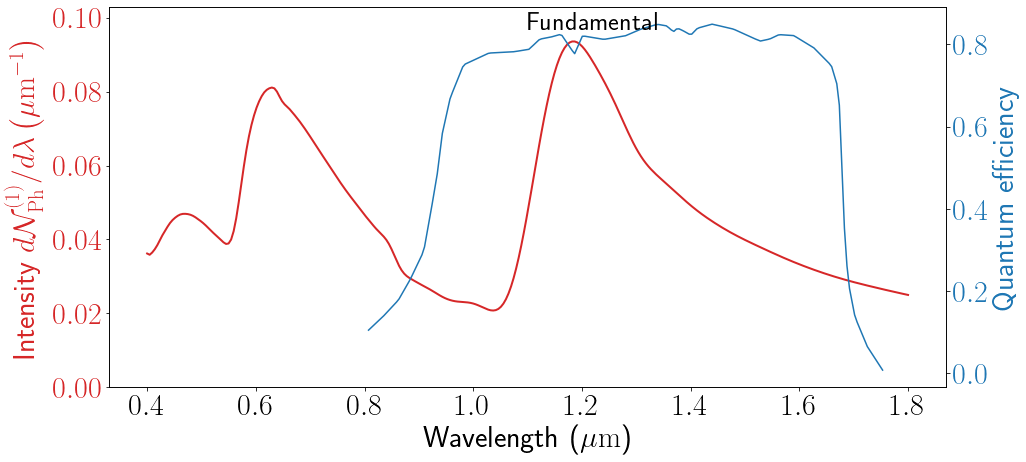

In [3]:
plt.rcParams["text.usetex"] =True
fig,ax = plt.subplots(figsize=[15,7])
ax.set_xlabel('Wavelength ($\mu \mathrm{m}$)')
color = 'tab:red'
sd = wr_sim.get_spectral_distribution()
plt.plot(l1d, sd, linewidth=2,color = color)
ax.set_ylabel(r'Intensity $d\mathcal{N}^{(1)}_{\mathrm{Ph}}/d\lambda \left(\mu \mathrm{m}^{-1}\right)$', color=color)
plt.tick_params(axis ='y',labelcolor=color)
# yfmt = ScalarFormatterForceFormat()
# yfmt.set_powerlimits((0,0))
# ax.yaxis.set_major_formatter(yfmt)  
plt.ylim(0,1.1*max(sd))
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'Quantum efficiency', color=color)  # we already handled the x-label with ax1
ax2.plot(
    l1d,
    np.where(spectral_transmission>0, spectral_transmission, np.nan),
    color=color)
# ax2.plot(wmin_plt,qe_int(wmin_plt),linestyle='--',color=color)
# ax2.plot(wmax_plt,qe_int(wmax_plt),linestyle='--',color=color)
ax2.tick_params(axis='y', labelcolor=color)
align_yaxis(ax, 0, ax2, 0)
plt.text(0.5,0.94,'Fundamental',fontsize=26,transform=ax.transAxes)
plt.savefig('/home/ilobach/PRAB_fluctuations_theory/images/iota_spectrum.png',bbox_inches='tight',dpi=300)
plt.show()

In [4]:
i3d = spectral_transmission[:, None, None]*wr_sim.get_photon_flux_3D()
tot = dx*dy*dl*np.sum(i3d)
x1_2D, x2_2D = np.meshgrid(x1d, x1d)
x1m2_2d = x1_2D-x2_2D
y1_2D, y2_2D = np.meshgrid(y1d, y1d)
y1m2_2d = y1_2D-y2_2D

In [5]:
def get_Mxy(sx, sy, i3d_in):
    res = 0
    tot = dx*dy*dl*np.sum(i3d_in)
    for slice2d, lmda in zip(i3d_in, l1d):
        Eexpx = np.tensordot(slice2d, lmda*np.exp(-(sx*2*np.pi/lmda*x1m2_2d)**2), (1,0))
        Eexpy = np.tensordot(slice2d, lmda*np.exp(-(sy*2*np.pi/lmda*y1m2_2d)**2), (0,1))
        res += np.tensordot(Eexpx, Eexpy.T)
    return tot**2/(dx*dy*dx*dy*dl*1/(2*np.sqrt(np.pi)*1e4)*res)

In [6]:
sx,sy = 815, 75
sz = 38
M = sz*get_Mxy(sx, sy, i3d)
print(f"{M:.1e}")

1.2e+07


In [7]:
def getM(l_start, l_end):
    filt = np.array([1 if ((l>l_start) and (l<l_end)) else 0 for l in l1d])
    return sz*get_Mxy(sx, sy, filt[:,None,None]*i3d)

In [9]:
ibeam = 1.3  # mA
N_av = tot*ibeam*get_from_config("IOTA_revolution_period")/1000/get_from_config("e")
print(f"{N_av:.1e}")

3.3e+07


In [19]:
bandpass1 = [1.05, 1.35]
bandpass2 = [1.15, 1.3]
M1 = getM(*bandpass1)
M2 = getM(*bandpass2)

In [20]:
M1, M2

(4864741.666250996, 2691507.8712752927)

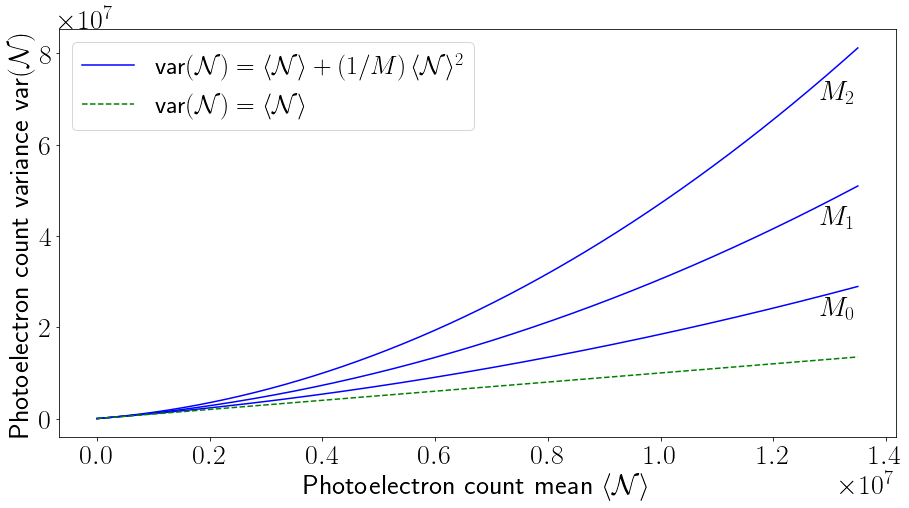

In [43]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig,ax = plt.subplots()
colors = ["blue", "blue", "blue"]
Mnames = [r"$M_0$", r"$M_1$", r"$M_2$"]
Mvalues = [M, M1, M2]
lines = []


min_x = 0.0e7
max_x=1.35e7
x_an = max_x*0.95
xx = np.linspace(min_x,max_x,1000)

for c, Mname, Mval in zip(colors, Mnames, Mvalues):
    lines.append(ax.plot(xx,xx+xx**2/Mval,color=c)[0])
    ax.annotate(Mname, (x_an, (x_an+x_an**2/Mval)-0.5e7))

lines[0].set_label(r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle+\left(1/"
    +r"M"
    +r"\right)\langle\mathcal{N}\rangle^2$")

ax.plot(xx, xx,color='green',linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")

plt.ylabel(r'Photoelectron count variance var$(\mathcal{N})$')
plt.xlabel(r'Photoelectron count mean $\langle\mathcal{N}\rangle$')

ax.legend( loc=2,prop = {'size':26})

plt.savefig("/home/ilobach/PRAB_fluctuations_theory/images/iota_prediction.png",dpi=300, bbox_inches='tight')

plt.show()
plt.close(fig)